# Notebook for Feature Analysis and ML 

## Imports

In [9]:
# Data
import pandas as pd
import numpy as np

In [10]:
# Misc
import os
from pprint import pprint as pp

In [11]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [12]:
# ML
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Config

In [13]:
# Pandas error display OFF
pd.options.mode.chained_assignment = None

# Data Path
data_path = "../data/"

# Image Path
img_path = "./plots/"

## Get Data

In [14]:
# Get Features
features = pd.read_csv(data_path+'features.csv').drop(['Unnamed: 0','product_uid'], axis=1)

## Feature Analysis

In [15]:
# Create ratio features using query length
features['title_ratio'] = features['com_title'] / features['q_len']
features['desc_ratio'] = features['com_desc'] / features['q_len']
features['attr_ratio'] = features['com_attr'] / features['q_len']

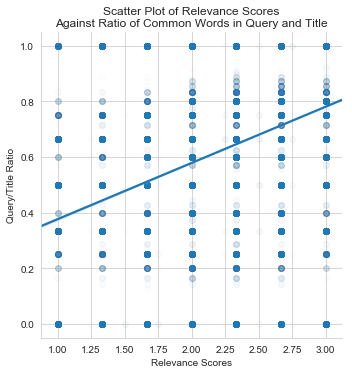

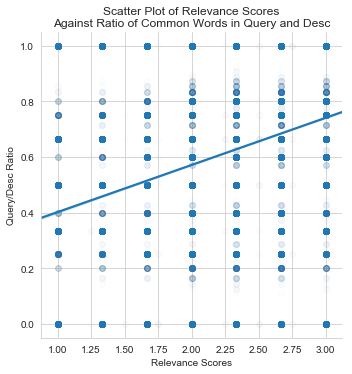

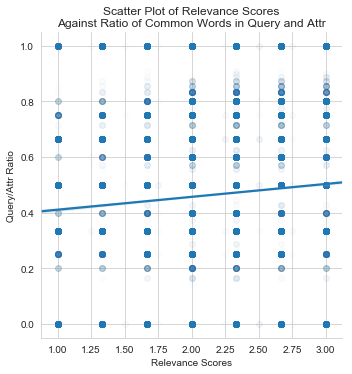

In [17]:
# For each ratio, create a linear regression plot against relevance
for x in ['title_ratio', 'desc_ratio', 'attr_ratio']:
    bit = x.split('_')[0].title()
    ax = sns.lmplot(x='relevance', y=x, data=features, scatter_kws={'alpha':0.01})
    plt.title('Scatter Plot of Relevance Scores\nAgainst Ratio of Common Words in Query and {}'.format(bit))
    plt.xlabel('Relevance Scores')
    plt.ylabel('Query/{} Ratio'.format(bit))
    # plt.savefig(img_path+'{}_ratio.png'.format(bit), dpi=500, bbox_inches="tight")

## ML Modelling

In [18]:
# Chose features
df = features.drop(['title_ratio', 'desc_ratio', 'attr_ratio'], axis=1)

In [19]:
# Split
X_train, X_test, y_train, y_test = train_test_split(df.drop('relevance',axis=1),
                                                    df['relevance'],
                                                    test_size=0.33, random_state=42)

In [20]:
# Gradient Boosted Tree Model
gbr = GradientBoostingRegressor(n_estimators=150, learning_rate=0.4, loss='huber', alpha=0.9)

# Random forest Model
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)

In [21]:
# Set Model
mdl = rf
model_name = 'Random_Forest'

In [22]:
# Fit Model
mdl.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [ ]:
# Show variable importance
importances = pd.np.nan
if mdl is gbr or mdl is rf:
    importances = pd.Series(data=mdl.feature_importances_, index=X_train.columns).sort_values(ascending=False)
if importances is not pd.np.nan:
    ax = importances.plot(kind='bar')
    plt.title('Bar Plot of Relative Importance of Features using the {} Model'.format(model_name))
    plt.xlabel('Feature')
    plt.ylabel('Relative Importance')
    plt.savefig(img_path+'{}_relimp.png'.format(model_name), dpi=500, bbox_inches="tight")

In [ ]:
# Predictions...
pred = mdl.predict(X_test)

In [ ]:
# Metrics
print('MSE: {:.4f}\nMAE: {:.4f}\nR2: {:.4f}'.format(mean_squared_error(y_test, pred), mean_absolute_error(y_test, pred), r2_score(y_test, pred), mdl.score(X_test, y_test)))
print('\nCross Validation')
print(cross_val_score(mdl, X_train, y_train))

In [ ]:
# Residuals
s = np.std(pred)
std_resids = (pred - y_test.values)/s
df = pd.DataFrame({"std_resids":std_resids, "preds":pred})
# df['Range'] = df['std_resids'].apply(lambda x: 'Within 2 stdevs' if (x>2.0 or x<-2.0) else 'Outwith 2 stdevs')
df['Range'] = df['std_resids'].apply(lambda x: 'r' if (x>2.0 or x<-2.0) else 'b')
ax = df.plot(kind='scatter', x='preds', y='std_resids', alpha=0.01, c=df['Range'].values)
plt.title('Scatter Plot of Residuals (in units of standard deviations)\nResidual Outwith 2 Stdev. has been Coloured Red')
plt.xlabel('Predicted Value')
plt.ylabel('Residual/Standard Deviation')
print('Proportion of residuals outwith 2 standard deviations: {}'.format(df['Range'].value_counts()['b']/len(df)))
plt.savefig(img_path+'{}_std_resids.png'.format(model_name), dpi=500, bbox_inches="tight")

In [ ]:
# Deviance for GBT - testing for over-fitting
if mdl is gbr:
    test_score = np.zeros((150,), dtype=np.float64)

    for i, y_pred in enumerate(mdl.staged_predict(X_test)):
        test_score[i] = mdl.loss_(y_test, y_pred)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Deviance')
    plt.plot(np.arange(150) + 1, mdl.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(np.arange(150) + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.title('Line Plot of Deviance of Test and Train Predictions\nAgainst Boosting Iterations when using Gradient Boosted Tree')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')
    plt.savefig(img_path+'gbr_dev.png', dpi=500, bbox_inches="tight")